# Jordan's scientific parameters: `jscip`


This package is designed to help with managing the set of parameters for a model, particularly in the context of other Python packages which expect certain parameter structures. 

In [1]:
from jscip import *

Here is an example of an independent parameter. A default value is specified, and also a range of valid values is set by the user.
So far, `jscip` only supports independent uniformly distributed parameters, but this may change in the future.  

In [2]:
a = IndependentParameter(value=3.14, is_sampled=True, range=(1, 6))
print(a)
print(" a.sample(3) : ", a.sample(3))

IndependentParameter(value=3.14, range=(1, 6), is_sampled=True)
 a.sample(3) :  [1.55191878 3.74812065 4.80809997]


A `ParameterBank` is a class that contains a dict of parameters so they may be managed altogether, along with a bunch of other features.

This bank is instatiated with three parameters. Two of those are sampled.

In [3]:
bank = ParameterBank(parameters={
    "dt": IndependentParameter(value=0.01),
    "a": IndependentParameter(value=-5, is_sampled=True, range=(-10, 0)),
    "b": IndependentParameter(value=7, is_sampled=True, range=(2, 12)),
})

# test parameter bank methods
print("names (all) : \n", bank.names)  # should return a list of parameter names in the bank
print("names (sampled only) : \n", bank.sampled)  # should return a list of only the sampled parameter names in the bank
print("default values : \n", bank.get_default_values())  # returns a ParameterSet with default values for each parameter

names (all) : 
 ['dt', 'a', 'b']
names (sampled only) : 
 ['a', 'b']
default values : 
 ParameterSet(dt    0.01
a    -5.00
b     7.00
dtype: float64)


Next we will look at sampling. By default, the `sample` method will return either an instance of a `ParameterSet` or a `pandas.DataFrame`. If you want to sample multiple times, you can specify the number of samples to return, or use a tuple of integers to specify the shape of the output array. 

```python

In [4]:
print("bank.sample() : \n", bank.sample())  # should return a dictionary with sampled values for each parameter
print("bank.sample(2) : \n", bank.sample(2))  
print("bank.sample((3,)) : \n", bank.sample((3,)))

bank.sample() : 
 ParameterSet(dt    0.010000
a    -3.791165
b     3.609471
dtype: float64)
bank.sample(2) : 
      dt         a          b
0  0.01 -1.334840   2.983932
1  0.01 -7.484362  10.499953
bank.sample((3,)) : 
      dt         a          b
0  0.01 -9.364936   3.667798
1  0.01 -0.882441  11.358207
2  0.01 -0.496390   3.776455


The `.sample(n)` method returns a list of n `ParameterSetInstance`s. This can be consilidated using `.consolidate_instances()`.


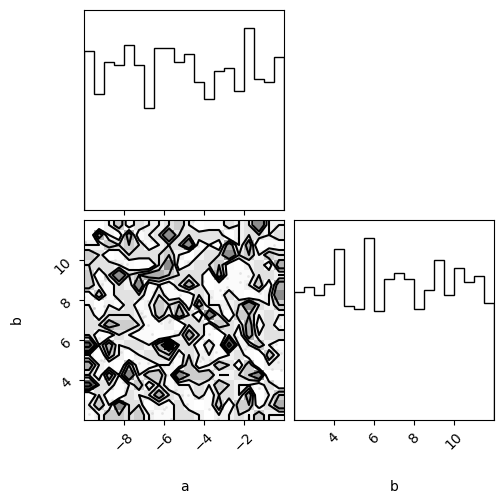

In [5]:
samples = bank.sample(1000)  # automatically will have dataframe structure
samples.drop(columns=["dt"], inplace=True)  # drop dt column since it is not sampled

# plot samples using corner
import corner
import matplotlib.pyplot as plt
_ = corner.corner(samples, labels=["a", "b"])

### Constraints

Upon instantiation, the `ParameterBank` can also be given a list of constraints. Each element of `constraints` must be a function that takes the parameter dictionary as a single argument and returns a boolean. For this, `lambda` is very useful, as shown below.



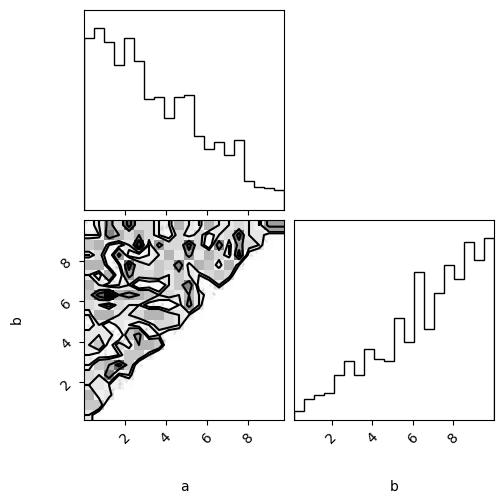

In [6]:
bank = ParameterBank(parameters={
    "a": IndependentParameter(value=5, is_sampled=True, range=(0, 10)),
    "b": IndependentParameter(value=7, is_sampled=True, range=(0, 10)),
}, constraints=[lambda p : p["a"] < p["b"]])

samples = bank.sample(1000)
_ = corner.corner(samples, labels=bank.names)

We have also introduced a `DerivedParameter` which is the only other type allowed in the bank. It takes a single argument, a function that takes the parameter dictionary as an argument and returns the value of the derived parameter. When getting values from the bank, all independent parameters are gotten first, then all derived parameters are computed from those. Thus, all derived parameters should probably depend on independent parameters exclusively.

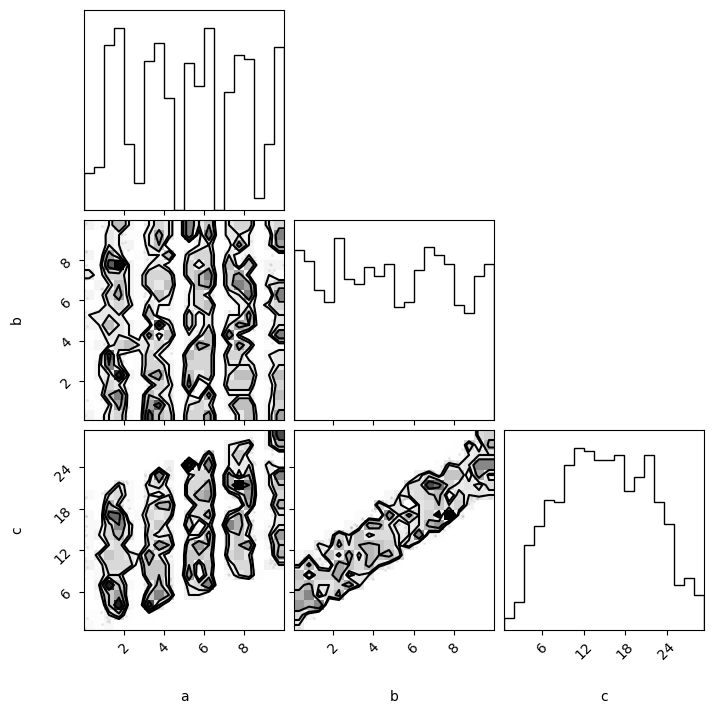

In [7]:
bank = ParameterBank(parameters={
    "a": IndependentParameter(value=5, is_sampled=True, range=(0, 10)),
    "b": IndependentParameter(value=7, is_sampled=True, range=(0, 10)),
    "c": DerivedParameter(function=lambda p: p['a'] + 2*p['b']),
}, constraints=[lambda p : np.sin(3*p['a']) < 0.5])


samples = bank.sample(1000)
_ = corner.corner(samples, labels=bank.names)

Other packages will also expect a `log_prob` method, which returns the log probability of the parameters given the constraints and limits. 

In [8]:
sample = bank.sample()
print("Sampled values: ", sample, type(sample))
print("log prob = ", bank.log_prob(sample))


sample = bank.sample((2,))
print("Sampled values: ", sample, type(sample))
print("log prob = ", bank.log_prob(sample))

Sampled values:  ParameterSet(a     3.266091
b     3.964459
c    11.195008
dtype: float64) <class 'jscip.ParameterSet'>
log prob =  0.0
Sampled values:            a         b          c
0  1.012018  6.957602  14.927221
1  3.073190  5.484550  14.042290 <class 'pandas.core.frame.DataFrame'>
log prob =  [0. 0.]


### $\theta$-array (theta) mode

The `ParameterBank` can also be used to sample "theta"-arrays, which are arrays of parameter values, in particular only the sampled parameters. This is useful for interfacing with other libraries that expect this format, such as `emcee` and `sbi`, but we still want to keep track of all parameters in the bank together.

In [9]:
bank = ParameterBank(parameters={
    "dt": IndependentParameter(value=0.01),
    "x": IndependentParameter(value=3, is_sampled=True, range=(0, 10)),
    "y": IndependentParameter(value=7, is_sampled=True, range=(0, 10)),
    "z": DerivedParameter(function=lambda p: p['x'] + 2*p['y']),
}, constraints=[lambda p : np.sin(3*p['x']) < 0.5],
                     theta_sampling=True)  # enable theta-sampling mode


# test parameter bank methods
print("names (all) : \n", bank.names)  # should return a list of parameter names in the bank
print("names (sampled only) : \n", bank.sampled)  # should return a list of only the sampled parameter names in the bank
print("default values : \n", bank.get_default_values())  # returns a ParameterSet with default values for each parameter

print("bank.sample() : \n", bank.sample())  # should return a dictionary with sampled values for each parameter
print("bank.sample(2) : \n", bank.sample(2))  
print("bank.sample((3,)) : \n", bank.sample((3,)))

names (all) : 
 ['dt', 'x', 'y', 'z']
names (sampled only) : 
 ['x', 'y']
default values : 
 [3. 7.]
bank.sample() : 
 [0.04986111 0.80844986]
bank.sample(2) : 
 [[0.15159315 7.64853691]
 [4.225648   8.1291845 ]]
bank.sample((3,)) : 
 [[8.04893282 3.57842298]
 [1.05275414 6.73227258]
 [5.59203854 2.79247077]]


With `theta_sampling=True`, the `sample` method will return a 1D or 2D numpy array of sampled parameters, depending on the number of samples requested. If we pass a tuple of integers, it will return a 2D array with the shape specified by the tuple. This is crucial to interface with libraries like `emcee` and `sbi`, which will use tuples for sizes.


In [10]:
array_sample =bank.sample((4,5))
print("bank.sample((4,5)).shape  \n", array_sample.shape)  # should return a 2D numpy array with shape (4, 5, # sampled parameters)

bank.sample((4,5)).shape  
 (4, 5, 2)


In [11]:
sample = bank.sample()
print("Sampled values: ", sample, type(sample))
print("log prob = ", bank.log_prob(sample))


sample = bank.sample((2,))
print("Sampled values: ", sample, type(sample))
print("log prob = ", bank.log_prob(sample))

Sampled values:  [4.11048583 9.55518779] <class 'numpy.ndarray'>
Converting 1D numpy array to ParameterSet instance.
log prob =  0.0
Sampled values:  [[5.94852025 4.67185665]
 [1.8422987  3.66073426]] <class 'numpy.ndarray'>
Converting 2D numpy array to list of ParameterSet instances.
log prob =  [0. 0.]
